In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (1080, 1920, 3)


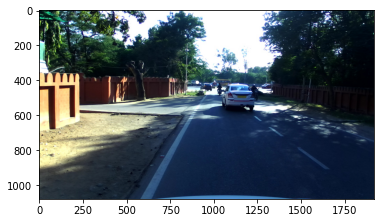

In [2]:
image = mpimg.imread('/content/frame15050.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [9]:
import math
def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
  return cv2.Canny(img, low_threshold, high_threshold)  

def gaussian_blur(img, kernel_size):
  return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
  mask = np.zeros_like(img)
  if len(img.shape) > 2:
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,) * channel_count
  else:
    ignore_mask_color = 255  
  cv2.fillPoly(mask, vertices, ignore_mask_color)
  masked_image = cv2.bitwise_and(img, mask)
  return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
  draw_right = True
  draw_left = True
  slope_threshold = 0.5
  slopes = []  
  new_lines = []
  for line in lines:
    x1, y1, x2, y2 = line[0]
    if x2 - x1 == 0:
      slope = 999.
    else:
      slope = (y2-y1)/(x2-x1)
    if abs(slope)>slope_threshold:
      slopes.append(slope)
      new_lines.append(line)

  lines = new_lines
  right_lines = []
  left_lines = []

  for i, line in enumerate(lines):
    x1, y1, x2, y2 = line[0]
    img_x_center = img.shape[1] / 2
    if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
      right_lines.append(line)
    elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
      left_lines.append(line) 
  right_lines_x = []
  right_lines_y = []

  for line in right_lines:
    x1, y1, x2, y2 = line[0]
    right_lines_x.append(x1)
    right_lines_x.append(x2)
        
    right_lines_y.append(y1)
    right_lines_y.append(y2)

  if len(right_lines_x) > 0:
    right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)
  else: 
    right_m, right_b = 1, 1
    draw_right = False

  left_lines_x = []
  left_lines_y = []

  for line in left_lines:
     x1, y1, x2, y2 = line[0]
        
     left_lines_x.append(x1)
     left_lines_x.append(x2)
        
     left_lines_y.append(y1)
     left_lines_y.append(y2)
     if len(left_lines_x) > 0:
       left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)
     else:
       left_m, left_b = 1, 1
       draw_left = False

  y1 = img.shape[0]
  y2 = img.shape[0] * (1 - trap_height)
    
  right_x1 = (y1 - right_b) / right_m
  right_x2 = (y2 - right_b) / right_m
    
  left_x1 = (y1 - left_b) / left_m
  left_x2 = (y2 - left_b) / left_m

  y1 = int(y1)
  y2 = int(y2)
  right_x1 = int(right_x1)
  right_x2 = int(right_x2)
  left_x1 = int(left_x1)
  left_x2 = int(left_x2)

  if draw_right:
    cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
  if draw_left:
    cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
  lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)  # this produces single-channel (grayscale) image
  line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  # 3-channel RGB image
  draw_lines(line_img, lines)
    #draw_lines_debug2(line_img, lines)
  return line_img  

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
  return cv2.addWeighted(initial_img, α, img, β, λ)

def filter_colors(image):
  white_threshold = 200
  lower_white = np.array([white_threshold, white_threshold, white_threshold])
  upper_white = np.array([255, 255, 255])
  white_mask = cv2.inRange(image, lower_white, upper_white)
  white_image = cv2.bitwise_and(image, image, mask=white_mask)

    # Filter yellow pixels
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  lower_yellow = np.array([90,100,100])
  upper_yellow = np.array([110,255,255])
  yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
  yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

  image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)

  return image2        
        

In [10]:
kernel_size = 3

# Canny Edge Detector
low_threshold = 50
high_threshold = 150

# Region-of-interest vertices
# We want a trapezoid shape, with bottom edge at the bottom of the image
trap_bottom_width = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
trap_top_width = 0.07  # ditto for top edge of trapezoid
trap_height = 0.4  # height of the trapezoid expressed as percentage of image height

# Hough Transform
rho = 2 # distance resolution in pixels of the Hough grid
theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 20    

In [11]:
def annotate_image(image_in):
  image = filter_colors(image_in)
    
    # Read in and grayscale the image
    #image = (image*255).astype('uint8')  # this step is unnecessary now
  gray = grayscale(image)

    # Apply Gaussian smoothing
  blur_gray = gaussian_blur(gray, kernel_size)

    # Apply Canny Edge Detector
  edges = canny(blur_gray, low_threshold, high_threshold)

    # Create masked edges using trapezoid-shaped region-of-interest
  imshape = image.shape
  vertices = np.array([[\
        ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
  masked_edges = region_of_interest(edges, vertices)

    # Run Hough on edge detected image
  line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw lane lines on the original image
  initial_image = image_in.astype('uint8')
  annotated_image = weighted_img(line_image, initial_image)
    
  return annotated_image

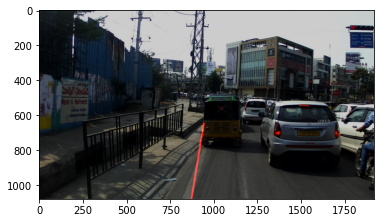

In [15]:
annotated_image = annotate_image(mpimg.imread('/content/frame0535.jpg'))
plt.imshow(annotated_image)

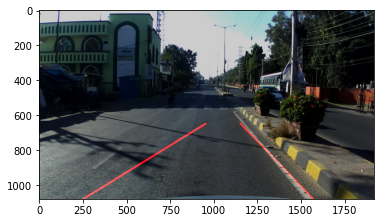

In [19]:
annotated_image = annotate_image(mpimg.imread('/content/frame16669.jpg'))
plt.imshow(annotated_image)

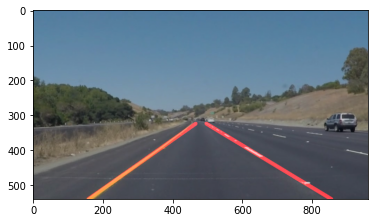

In [33]:
annotated_image = annotate_image(mpimg.imread('/content/solidYellowCurve.jpg'))
plt.imshow(annotated_image)